In [1]:
%load_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')

In [2]:
import sys
sys.path.append('../')
import dataset_wrapper as util

In [3]:
import ee
ee.Authenticate() 
ee.Initialize()


Successfully saved authorization token.


In [ ]:
import geopandas as gpd
dataframe = gpd.read_file('/data2/hkaman/Data/CDL/California_Counties.geojson')
dataframe = dataframe.to_crs(epsg=4326)
dataframe

In [5]:
import geopandas as gpd

gdf = gpd.read_file("/home/hkaman/Documents/CA-YieldBenchmark-Foundation-Model/dataset/download_county_dataset/merged_geometry.geojson")
gdf.to_file("/home/hkaman/Documents/CA-YieldBenchmark-Foundation-Model/dataset/download_county_dataset/merged_geometry.shp")

### Climate data

In [4]:
county_names = dataframe['NAME'].str[:-7].tolist()
county_names = county_names[33:34]
county_names

['Sacramento']

In [ ]:
dataset = util.DownloadClimateEE(year = 2022, county_name= None)()

In [8]:
for name in county_names: 
    for year in range(2022, 2023):
        if year != 2012: 
            dataset = util.DownloadClimateEE(year = year, county_name= name)()

NetCDF file saved to /data2/hkaman/Data/FoundationModel/Sacramento/Climate/2022/DayMet_Sacramento_2022.nc


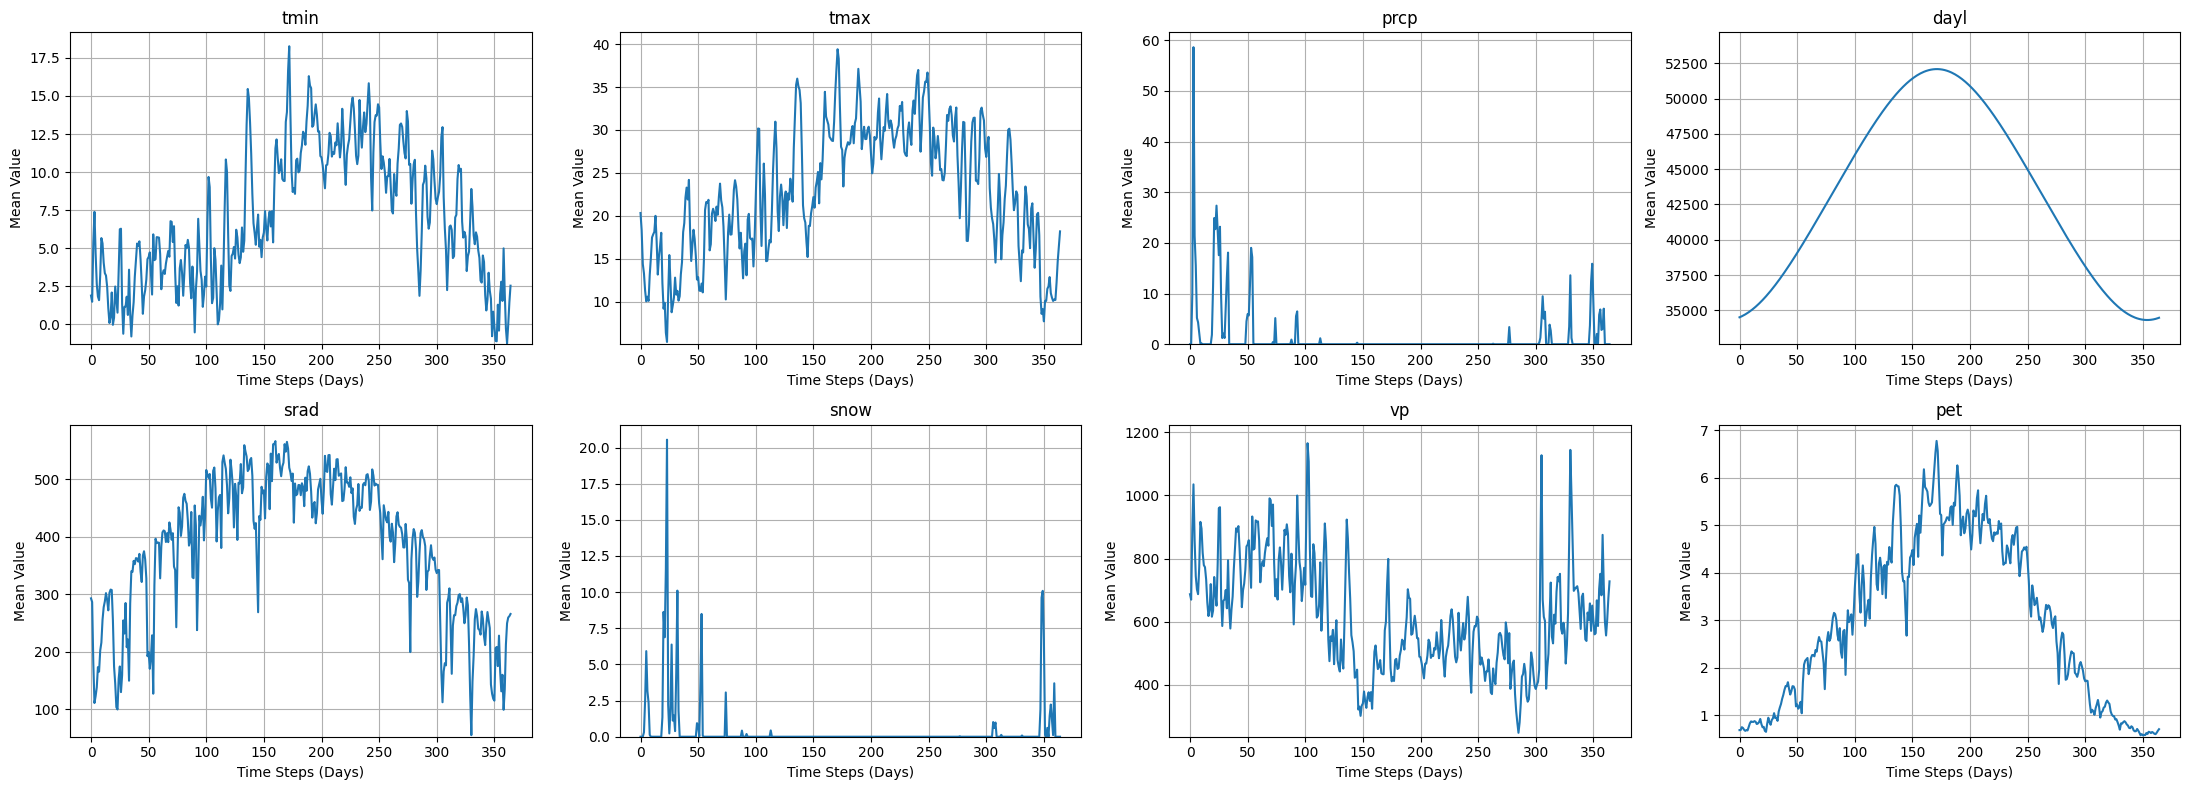

In [55]:
import numpy as np
time_steps = 365
spatial_dims = (128, 148)
variable_names = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'snow', 'vp', 'pet']
fig, axs = plt.subplots(2, 4, figsize=(22, 8))

# Plot each variable's mean time series
for i, var_name in enumerate(variable_names):
    row, col = divmod(i, 4)  # Compute row and column index for axs
    ax = axs[row, col]  # Access the subplot in the 2x4 grid

    # Compute the mean over spatial dimensions (latitude and longitude)
    mean_time_series = ds[var_name].mean(axis=(1, 2))  # Mean over spatial dimensions

    # Plot the mean time series
    ax.plot(mean_time_series, label=var_name)
    ax.set_title(var_name)  # Set the title for each subplot
    ax.set_xlabel("Time Steps (Days)")
    ax.set_ylabel("Mean Value")

    # Set individual y-axis range based on data
    ax.set_ylim(mean_time_series.min() - 0.05 * abs(mean_time_series.min()), 
                mean_time_series.max() + 0.05 * abs(mean_time_series.max()))

    ax.grid(True)

# Adjust layout for better spacing
plt.tight_layout()
plt.show()

In [5]:
import numpy
import xarray
import os 

root_dir = '/data2/hkaman/Data/FoundationModel/Inputs'
county_name = 'Fresno'
yr = 2022
climate_path = os.path.join(root_dir, county_name, f"Raw/Climate/{yr}/DayMet_{county_name}_{yr}.nc")
target_crs = "EPSG:32610"



variables = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'vp', 'snow', 'pet']
vector_timeseries, matrix_timeseries = [], []


climate_data = xarray.open_dataset(climate_path)[variables]
daymet_crs = "+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +ellps=WGS84 +units=m +no_defs"
climate_data = climate_data.rio.write_crs(daymet_crs)

climate_data = climate_data.rio.reproject(target_crs , resolution=(1000, 1000))
climate_bounds = climate_data.rio.bounds()
# aligned_bounds = (591345.0, 3962475.0, 751815.0, 4086765.0)  # From previous calculation
climate_data = climate_data.rio.clip_box(*climate_bounds)

target_shape = (climate_data.rio.height, climate_data.rio.width)


daily = True
time_steps = climate_data.time

for time_step in time_steps:
    time_slice = climate_data.sel(time=time_step) if daily else climate_data.sel(month=time_step)

    climate_stack = numpy.stack(
        [time_slice[var].values for var in variables],
        axis=0
    ).astype(numpy.float32)

    # climate_stack = numpy.nan_to_num(climate_stack, nan=0) 
    vector_timeseries.append(climate_stack)

vector_out = numpy.stack(vector_timeseries, axis=0)

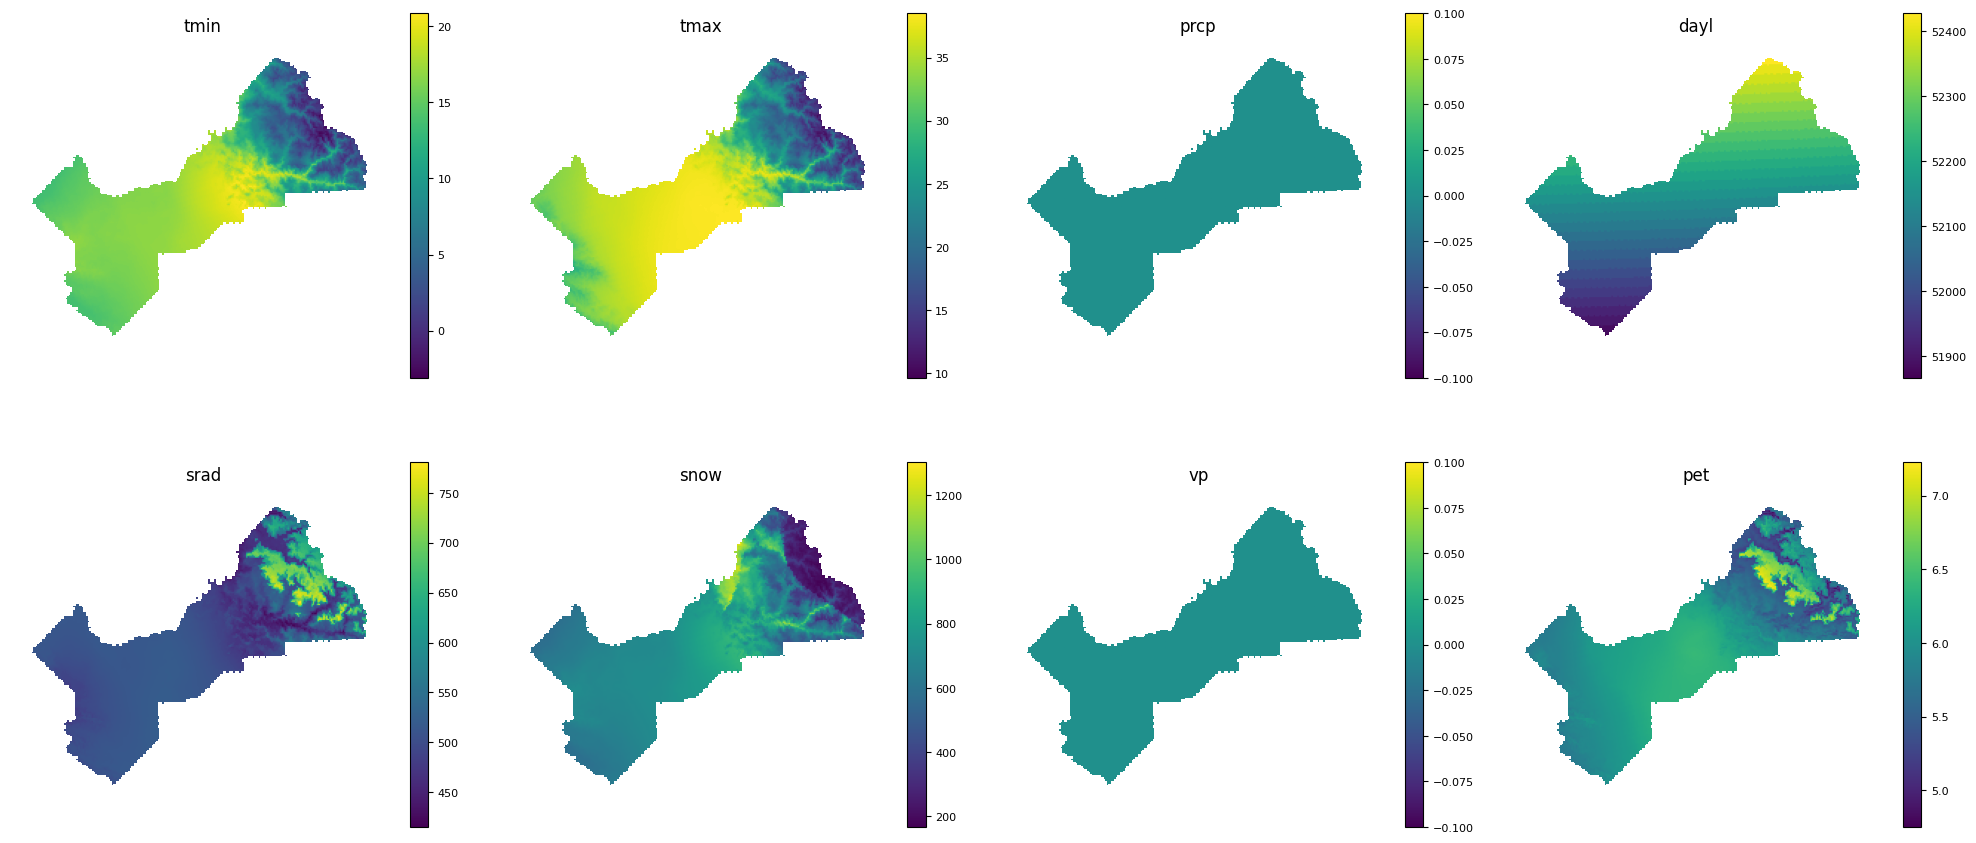

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = [0, 1, 2, 3]
variable_names = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'snow', 'vp', 'pet']

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, var_name in enumerate(variable_names):
    row, col = divmod(i, 4)
    ax = axs[row, col]

    data = vector_out[180, i, ...]
    im = ax.imshow(data, cmap='viridis')
    ax.set_facecolor("white")
    ax.set_title(var_name)
    ax.axis('off')

    # Attach a slightly smaller colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

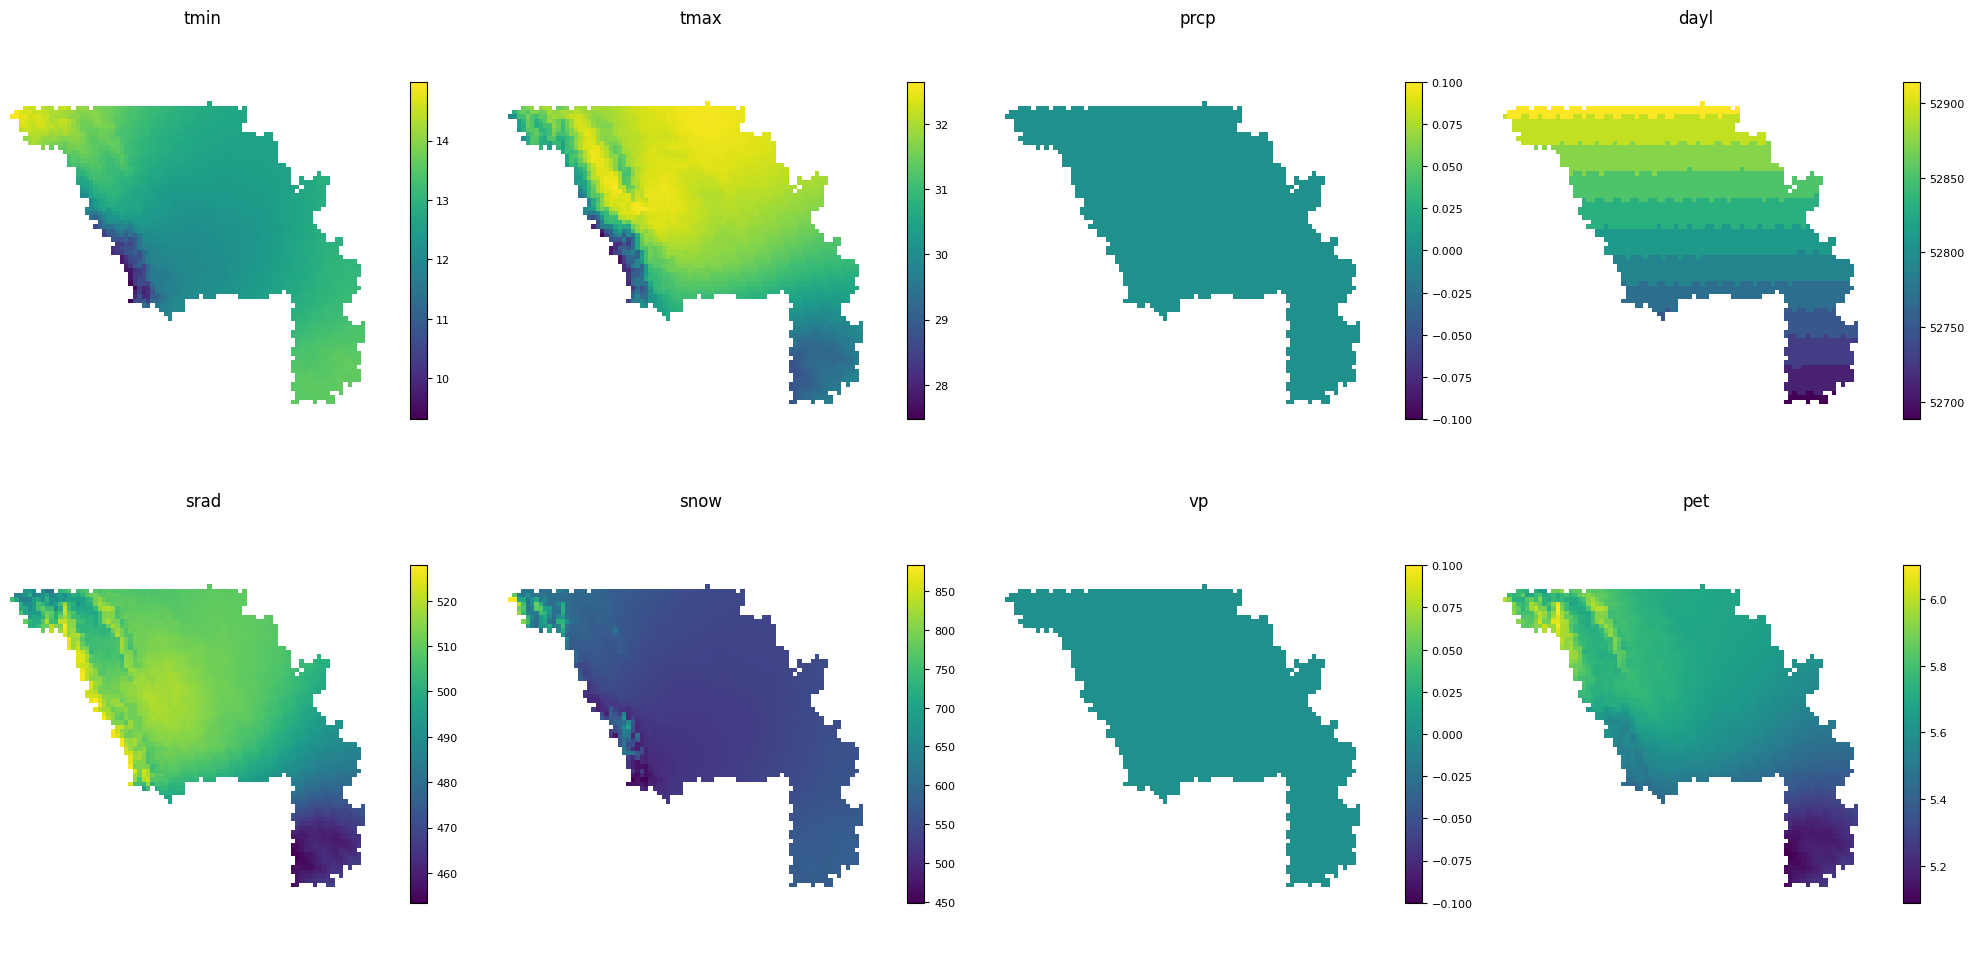

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = [0, 1, 2, 3]
variable_names = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'snow', 'vp', 'pet']

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, var_name in enumerate(variable_names):
    row, col = divmod(i, 4)
    ax = axs[row, col]

    data = vector_out[180, i, ...]
    im = ax.imshow(data, cmap='viridis')
    ax.set_facecolor("white")
    ax.set_title(var_name)
    ax.axis('off')

    # Attach a slightly smaller colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()

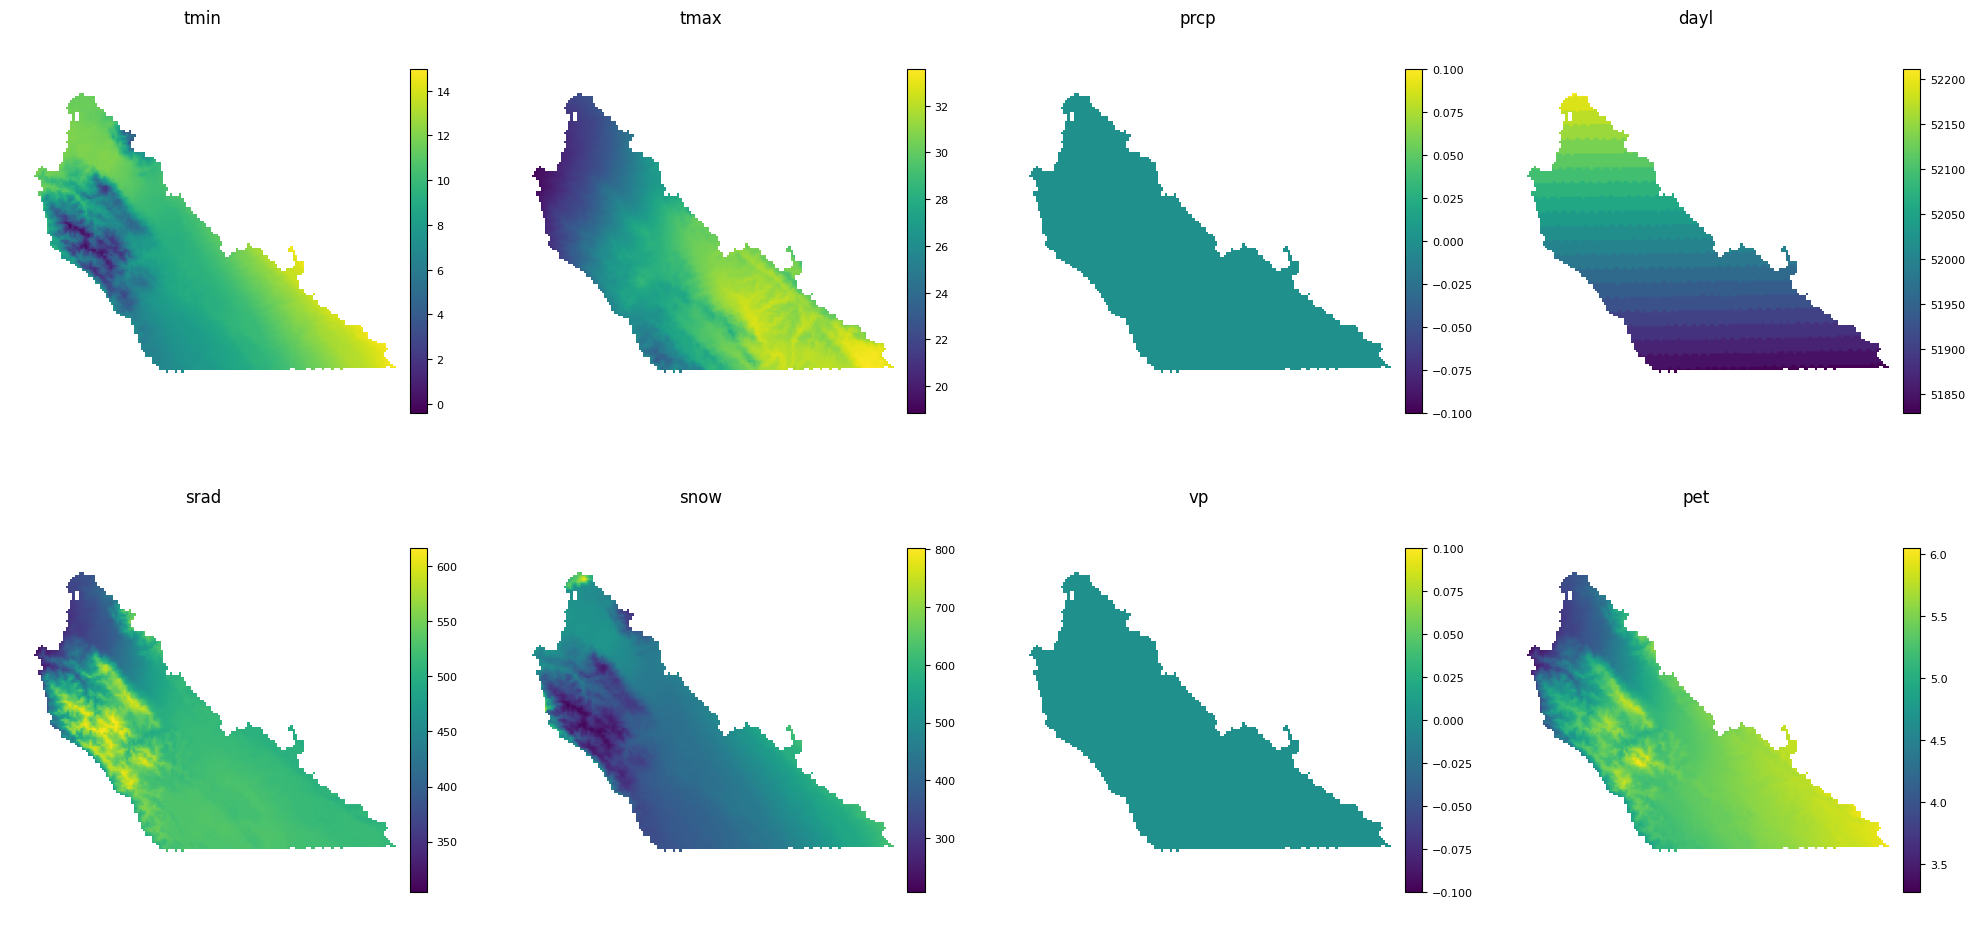

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

variables_to_plot = [0, 1, 2, 3]
variable_names = ['tmin', 'tmax', 'prcp', 'dayl', 'srad', 'snow', 'vp', 'pet']

fig, axs = plt.subplots(2, 4, figsize=(20, 10))

for i, var_name in enumerate(variable_names):
    row, col = divmod(i, 4)
    ax = axs[row, col]

    data = vector_out[180, i, ...]
    im = ax.imshow(data, cmap='viridis')
    ax.set_facecolor("white")
    ax.set_title(var_name)
    ax.axis('off')

    # Attach a slightly smaller colorbar
    cbar = fig.colorbar(im, ax=ax, orientation='vertical', shrink=0.7, pad=0.03)
    cbar.ax.tick_params(labelsize=8)

plt.tight_layout()
plt.show()